<h3>Train Autoencoder on Strucutred Data</h3>
<p>Train the autoencoder on the structured data and use the reconstruction error for each sample as an anomaly score.</p>
<p>Samples with higher reconstruction errors may represent more severe health conditions</p>

2024-10-13 17:46:29.480935: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-13 17:46:29.481046: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-13 17:46:29.481064: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-13 17:46:29.481413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-13 17:46:29.481743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-10-13 17:46:30.494507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - loss: 1.0383 - val_loss: 0.9161
Epoch 2/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.9162 - val_loss: 0.9123
Epoch 3/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.9432 - val_loss: 0.9105
Epoch 4/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.9089 - val_loss: 0.9093
Epoch 5/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.9111 - val_loss: 0.9089
Epoch 6/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.9042 - val_loss: 0.9081
Epoch 7/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.9095 - val_loss: 0.9081
Epoch 8/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.9159 - val_loss: 0.9082
Epoch 9/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.9291 - val_loss: 0.9082
Epoch 10/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.9320 - val_loss: 0.9077
Epoch 11/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.9155 - val_loss: 0.9080
Epoch 12/50
2922/29

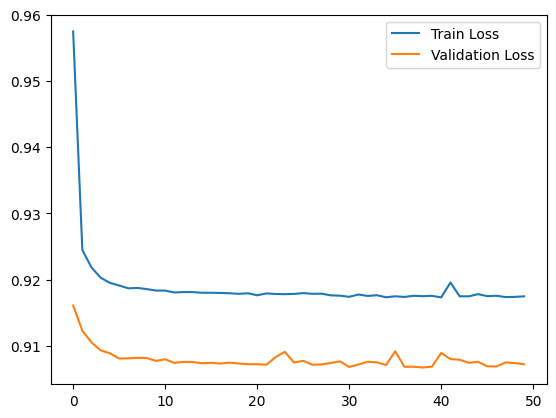

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# from tensorflow.python.keras.layers import layers, models
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt

# Load preprocessed structured data
structured_data = pd.read_csv('structured_data_preprocessed.csv')

# Convert DataFrame to numpy array
X_structured = structured_data.values

# Train-test split (since we don't have labels, we can use all data for training)
# But we'll reserve some data for validation purposes
from sklearn.model_selection import train_test_split

X_train_structured, X_val_structured = train_test_split(
    X_structured, test_size=0.2, random_state=42
)

# Define the autoencoder architecture
input_dim = X_train_structured.shape[1]
encoding_dim = 32  # Adjust as needed

# Encoder
input_structured = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_structured)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder Model
autoencoder = models.Model(inputs=input_structured, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(
    X_train_structured, X_train_structured,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val_structured, X_val_structured)
)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

<h3>Compute Reconstruction Error</h3>
<p>After trainig the autoencoder, we will compute the reconstruction error for each patient</p>
<p>The reconstruction error serves as an <strong>anomaly score</strong>. We can interpret higher reconstruction errors as higher severity levels.</p>

3652/3652 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


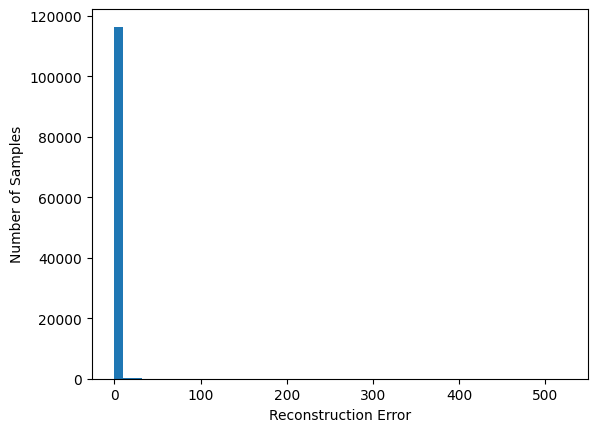

In [3]:
# Compute reconstruction error for each sample
reconstructed = autoencoder.predict(X_structured)
reconstruction_error = np.mean(np.power(X_structured - reconstructed, 2), axis=1)

# Add reconstruction error to the DataFrame
structured_data['reconstruction_error'] = reconstruction_error

# Plot the distribution of reconstruction errors
plt.hist(reconstruction_error, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.show()

<h3>Process Unstructured Data with Transformer Model</h3>
<p>We will use the BERT model to obtain embeddings from the clinical notes.</p>
<p>The embeddings represent the latenet features of the unstructued data.</p>

In [5]:
%pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.1/236.1 MB 72.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflo

In [13]:
import pandas as pd

combined_df = pd.read_csv('unstructured_data_preprocessed.csv')

# Print the first few entries of 'Token_IDs_Padded'
print(combined_df['Token_IDs_Padded'].head())

0    [  101 16798  2509  1011  2260  1011  2385  10...
1    [  101 16798  2549  1011  5511  1011  2322  10...
2    [  101 16798  2475  1011  5641  1011  2423  10...
3    [  101 16798  2549  1011  5718  1011  2756  10...
4    [  101 16798  2549  1011  5641  1011  2676  10...
Name: Token_IDs_Padded, dtype: object


In [14]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
import numpy as np
import pandas as pd

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load preprocessed unstructured data
combined_df = pd.read_csv('unstructured_data_preprocessed.csv')

# Define a custom parser function
def parse_token_ids(token_str):
    # Remove brackets and strip whitespace
    token_str = token_str.strip('[]').strip()
    # Split by any whitespace
    tokens = token_str.split()
    # Convert strings to integers
    tokens = [int(token) for token in tokens]
    return tokens

# Apply the custom parser
combined_df['Token_IDs_Padded'] = combined_df['Token_IDs_Padded'].apply(parse_token_ids)
combined_df['Attention_Masks_Padded'] = combined_df['Attention_Masks_Padded'].apply(parse_token_ids)

# Convert to tensors
input_ids = tf.constant(np.array(combined_df['Token_IDs_Padded'].tolist()), dtype=tf.int32)
attention_masks = tf.constant(np.array(combined_df['Attention_Masks_Padded'].tolist()), dtype=tf.int32)

# Get BERT embeddings
bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_masks)
unstructured_embeddings = bert_outputs.pooler_output.numpy()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

ResourceExhaustedError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[116842,512,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=tf.Tensor(shape=(116842, 512), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(116842, 512), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

<h3>Combine Latent Representaions</h3>
<p>We combine the reconstruction error from the structured data and the embeddings from the unstructured data.</p>

In [ ]:
# Create a DataFrame to hold all features
latent_features_df = pd.DataFrame()

# Add reconstruction error
latent_features_df['reconstruction_error'] = reconstruction_error

# Add unstructured embeddings
# Assuming unstructured_embeddings is a numpy array of shape (num_samples, embedding_dim)
embedding_dim = unstructured_embeddings.shape[1]
for i in range(embedding_dim):
    latent_features_df[f'embedding_{i}'] = unstructured_embeddings[:, i]

# Optionally, add latent features from the structured autoencoder
# Extract latent representations from the encoder part of the autoencoder
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output)
structured_latent = encoder.predict(X_structured)

latent_dim = structured_latent.shape[1]
for i in range(latent_dim):
    latent_features_df[f'structured_latent_{i}'] = structured_latent[:, i]

# Now we have a combined set of latent features

<h3>Apply Clustering Algorithm</h3>
<p>We apply a clustering algorithm on the combined latent features to idnentify groups of patients that may correspond to different levels of health severity.</p>
<p>We use K-Means clustering to group patients based on their latent features</p>
<p>The silhouette score helps determine the optimal number of clusters</p>

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the silhouette score
range_n_clusters = list(range(2, 10))
best_n_clusters = 0
best_score = -1

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_features_df)
    silhouette_avg = silhouette_score(latent_features_df, cluster_labels)
    print(f'For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}')
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

print(f'Best number of clusters: {best_n_clusters}')

# Apply KMeans with the best number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features_df)

# Add cluster labels to the DataFrame
latent_features_df['cluster'] = cluster_labels

<h3>Assign Health Severity Index</h3>
<p>We assing a severit index based on the cluster assignments.</p>
<p>Clusters represent different groups of patients with varying health conditions</p>
<p>By assinging severity scores based on cluster labels, we derive a health severiy index without human bias</p>

In [ ]:
# Map clusters to severity scores
# Assuming higher cluster labels correspond to higher severity
# If not, you may need to analyze clusters to order them appropriately

# Map cluster labels to severity scores (e.g., 0 to N-1)
latent_features_df['severity_index'] = latent_features_df['cluster']

# Optionally, scale severity index to 0-10 range
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 10))
latent_features_df['severity_index_scaled'] = scaler.fit_transform(latent_features_df[['severity_index']])

# Add the severity index back to the original data
combined_df['severity_index'] = latent_features_df['severity_index_scaled']

<h3>Analyse and Validate Clusters</h3>
<p>It's important to analyse the clusters to ensure they make clinical sense.</p>
<p>By exmamining the characteristics of each cluster, you can interpret the severity levles.</p>
<p>*look for patterns in the data that correlate with the clusters*</p>

In [ ]:
# Merge structured data with cluster labels
analysis_df = structured_data.copy()
analysis_df['cluster'] = latent_features_df['cluster']

# Group by cluster and compute summary statistics
cluster_summary = analysis_df.groupby('cluster').mean()

print(cluster_summary)

# Visualize clusters
import seaborn as sns

# Example: Plot reconstruction error vs. cluster
sns.boxplot(x='cluster', y='reconstruction_error', data=latent_features_df)
plt.show()

# Example: Plot any other relevant features
sns.boxplot(x='cluster', y='AGE', data=combined_df)
plt.show()